QCB311/COS311 PSET #4

Jairam Hathwar
April 6th, 2023

This represents my own work in accordance with University regulations. /s/ Jairam Hathwar


# Question 2

### a)
1,385 cells profiled

### b)
27,549 mean reads per cell

### c)
5,111 Median UMI Counts per Cell

### d)
2,406 median genes per cell

### e)
The discrepancy can be attributed to damaged or poor quality cells, PCR amplification bias, and differences in library preparation and sequencing depth between cells. These factors can affect the number of reads per cell differently than the number of UMIs per cell, leading to a discrepancy between the two values.


In [74]:
#install necessary packages
!pip install scanpy
!pip install leidenalg

import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import os
import scipy.io as sio
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [75]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.10.1 pandas==1.4.4 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.8


In [76]:
# Import the file as an 'AnnData' object (currently saved in matrix format (.mtx)
adata = sc.read_10x_mtx('./sample',  # the directory with the `.mtx` file
    var_names='gene_symbols',  # use gene symbols (stored within the .mtx file along w/ the UMIs) for the variable names (variables-axis index)
    cache=True)               
print(adata)

... reading from cache file cache/matrix.h5ad
AnnData object with n_obs × n_vars = 1385 × 32285
    var: 'gene_ids', 'feature_types'


In [77]:
# Since we are using gene symbols, rather than gene IDs, we need to make the names unique (multiple genes can have the same symbol)
adata.var_names_make_unique()

In [78]:
adata

AnnData object with n_obs × n_vars = 1385 × 32285
    var: 'gene_ids', 'feature_types'

normalizing counts per cell
    finished (0:00:00)


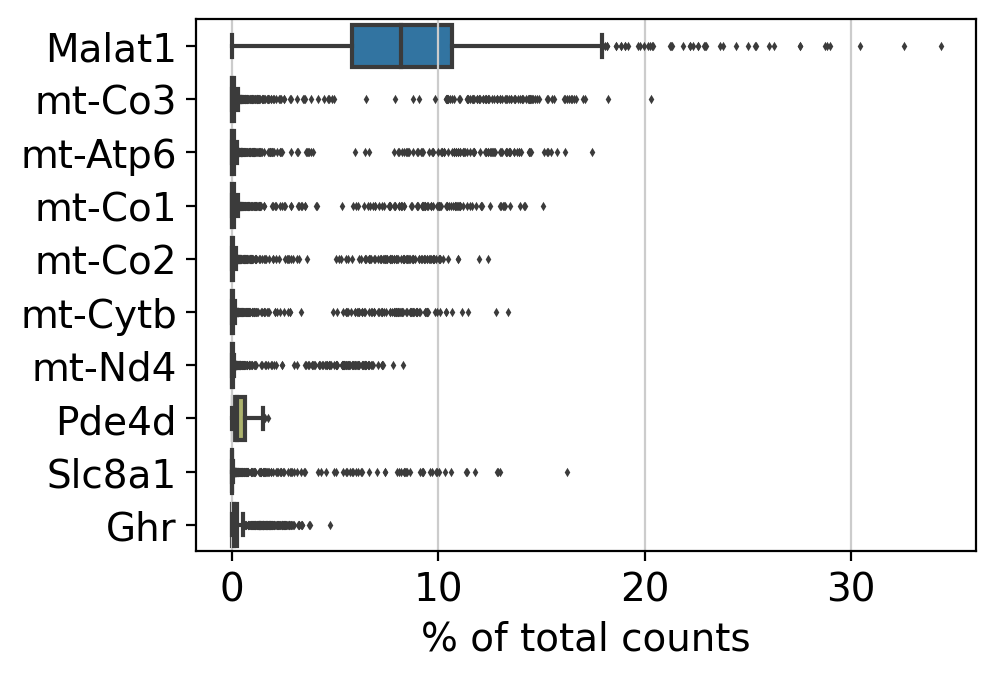

In [79]:
sc.pl.highest_expr_genes(adata, n_top=10) 

### f)
A boxplot of the top 10 most highly expressed genes in the dataset is shown above. Evidently, MALAT1 (Metastasis Associated Lung Adenocarcinoma Transcript 1) gene is the most highly expressed gene, which makes sense because it is a well documented non-coding RNA which is highly conserved amongst mammals and highly expressed in the nucleus.




In [80]:
# gi)
frac = np.sum(adata.X.todense() > 0) / np.prod(adata.X.shape)
print('Fraction of non-zeros:' + str(frac))

Fraction of non-zeros:0.08123485048828993


### gi)
As seen above, the density value (i.e. fraction of non-zeros) is ~0.081. 

In [81]:
# gii)
sc.pp.filter_cells(adata, min_genes=300)

filtered out 28 cells that have less than 300 genes expressed


### gii)
As seen above, there were filtered out 28 cells that have less than 300 genes expressed.

In [82]:
# giii)
sc.pp.filter_genes(adata, min_cells=4)

filtered out 14677 genes that are detected in less than 4 cells


### giii)
As seen above, there were filtered out 14677 genes that are detected in less than 4 cells

In [83]:
# giv)
# Label genes starting with "MT-" (i.e. mitochondrial genes) as 'mt', storing designation as a new variable for each cell
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.pct_counts_mt <= 5, :]
adata

View of AnnData object with n_obs × n_vars = 1357 × 17608
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### giv)
Evidently, there were no cells filtered out in this step, and the absence of filtered cells in this step suggests that the dataset has low mitochondrial gene expression or that any cells with high mitochondrial gene expression are within the expected range of biological or technical variation. Additionally, it is possible that some cells were already filtered out in the previous steps.

In [84]:
# gv)
adata = adata[adata.obs.total_counts <= 50000, :]
adata = adata[adata.obs.n_genes_by_counts < 8000, :]
adata

View of AnnData object with n_obs × n_vars = 1343 × 17608
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### gv)
As seen above, there were 14 cells filtered as a result of removing cells with a total UMI count greater than 50,000 and cells in which greater than 8,000 genes were detected at UMI > 0.

In [85]:
# gvi)
adata

View of AnnData object with n_obs × n_vars = 1343 × 17608
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### gv)
As shown above, we are left with 1343 cells and 17608 genes.

In [86]:
# gvii)
frac = np.sum(adata.X.todense() > 0) / np.prod(adata.X.shape)
print('Fraction of non-zeros:' + str(frac))

Fraction of non-zeros:0.14743755207728973


### gv)
We now have a fraction of non-zeros of ~0.147. Evidently, the filtered matrix is less sparse than the unfiltered matrix because the fraction of non-zeros increased from ~0.081 to ~0.147.

extracting highly variable genes


/usr/local/lib/python3.9/dist-packages/scanpy/experimental/pp/_highly_variable_genes.py:67: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)


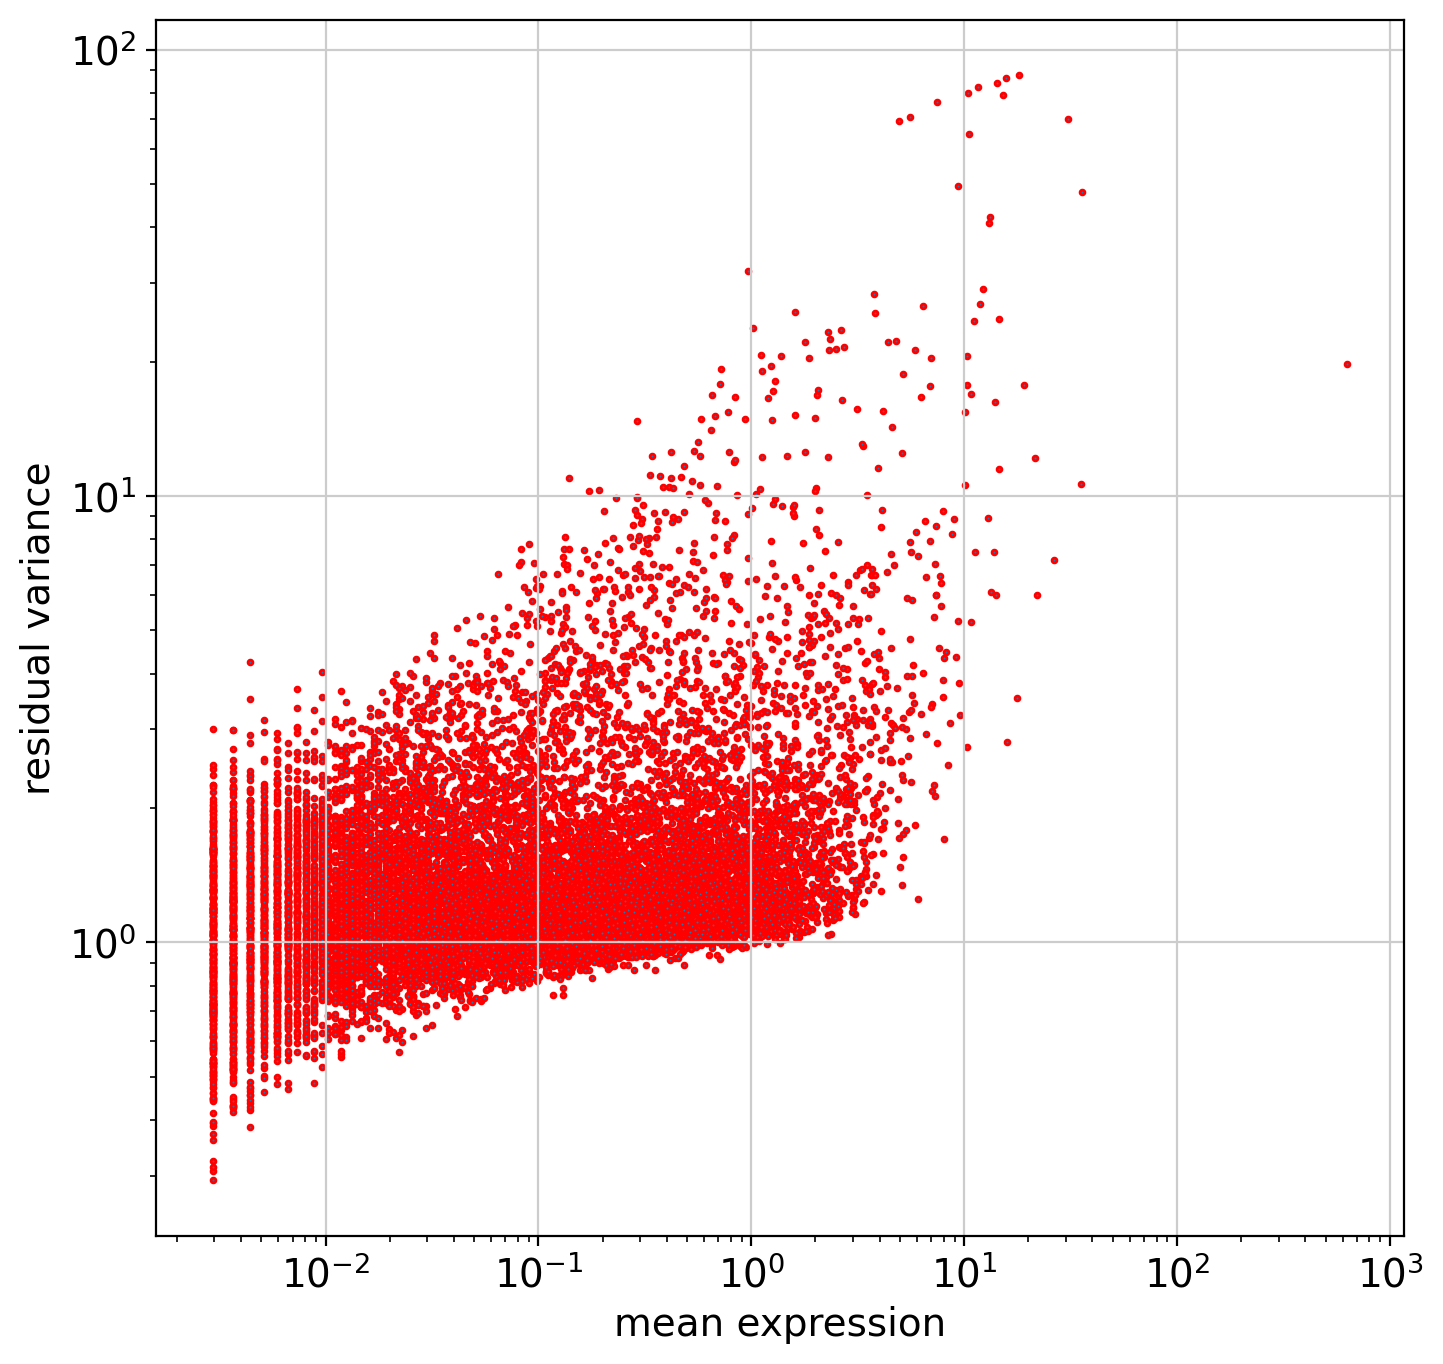

             value
mt-Co3   87.759644
mt-Atp6  86.633537
mt-Co1   84.156937
mt-Co2   82.361198
mt-Cytb  79.821678


In [87]:
# h)
sc.experimental.pp.highly_variable_genes(adata, flavor="pearson_residuals", n_top_genes=500) 

plt.figure(figsize=(8,8))
plt.scatter(adata.var["mean_counts"], adata.var["residual_variances"], s=3, edgecolor="red")

plt.xscale('log')
plt.yscale('log')

plt.xlabel("mean expression")
plt.ylabel("residual variance")
plt.show()

top_values = adata.var["residual_variances"].nlargest(5)
df_top = pd.DataFrame({'value': top_values})
print(df_top)

### h)
Evidently, the scatter plot of the mean expression of genes (x-axis) vs. the residual variance (y-axis), using log-scale for both x- and y-axes is shown above. Additionally, a table of the top 5 most variable genes with their Pearson residual is displayed directly beneath. Notably, all 5 of these gene names share the prefix mt-, which indicates that the gene is involved in mitochondrial function. Mitochondrial genes can be highly variable across different cell types and can be used as a quality control metric for single-cell RNA sequencing data, so that explains why these genes are the most variable.

In [88]:
# i)
adata.layers["raw"] = adata.X.copy()
adata.layers["libsize_norm"] = sc.pp.normalize_total(adata, inplace=False)["X"]
sc.experimental.pp.normalize_pearson_residuals(adata)

normalizing counts per cell
    finished (0:00:00)
computing analytic Pearson residuals on adata.X
    finished (0:00:00)


In [89]:
# ii)
# print first 10 lines of observation matrix (obs)
print(adata.obs.head(10))

# print first 10 lines of variable matrix (var)
print(adata.var.head(10))

                    n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAAGTAAACGT-1     3194               3186        6552.0              0.0   
AAACCCACAACCGTAT-1     6270               6260       23892.0              0.0   
AAACCCATCACCTTAT-1     3950               3948       10512.0              0.0   
AAACGCTTCCGTAATG-1     3346               3343        8818.0              0.0   
AAACGCTTCTTACCGC-1     2545               2545        6405.0              0.0   
AAAGAACCAGAGTTGG-1     5557               5549       18410.0              0.0   
AAAGTCCGTGAAGCGT-1     2411               2405        4664.0              0.0   
AAAGTGAGTCGTACTA-1     4277               4274       11033.0              0.0   
AAAGTGAGTCGTGATT-1     2598               2596        5385.0              0.0   
AAATGGAAGTGTTGAA-1     2684               2679        5934.0              0.0   

                    pct_counts_mt  
AAACCCAAGTAAACGT-1            0.0  
AAACCCACAACCGTAT-1            0.0  


### ii)
The first 10 lines of the observation matrix (“obs”) and variable matrix (“var”) are shown above. The rownames of the observation matrix represent the cell barcodes, which are unique molecular identifiers (UMIs) that identify each cell.

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


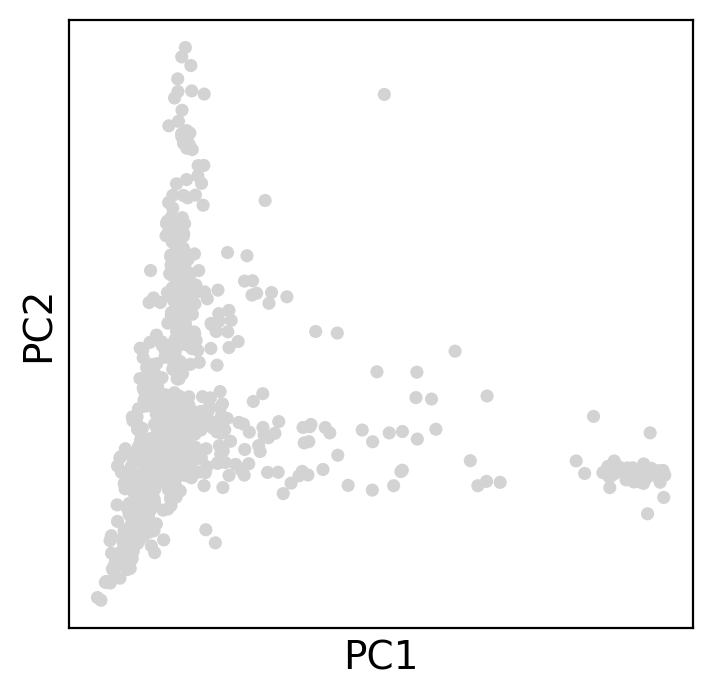

In [90]:
# ji)
sc.pp.pca(adata, n_comps=50) 
sc.pl.pca(adata)

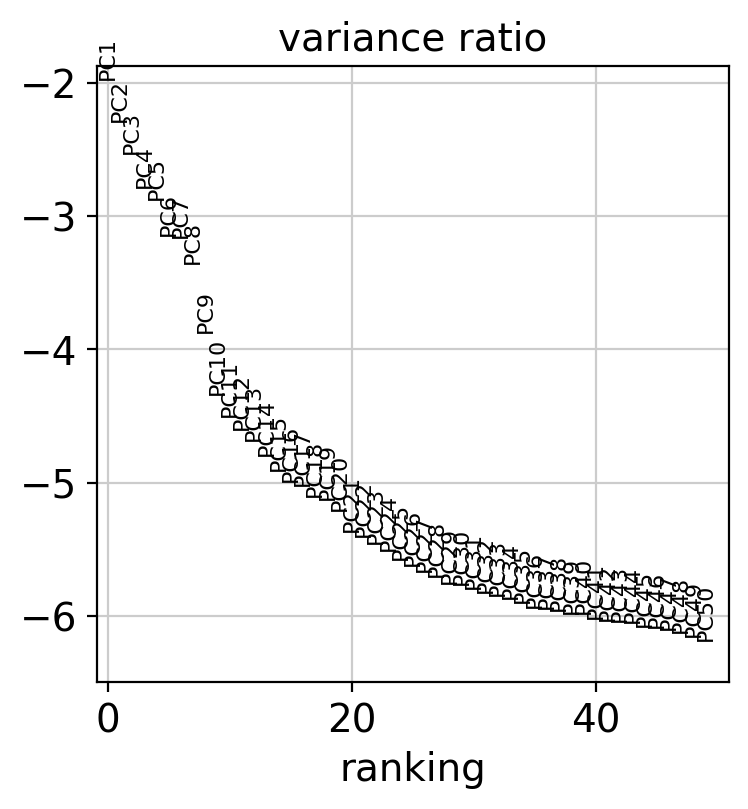

In [91]:
# jii)
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [92]:
# jiii)
# run PCA
sc.tl.pca(adata, n_comps=30)

# calculate variance explained by first 30 PCs
variance_explained = sum(adata.uns['pca']['variance_ratio'][:30])
print(f"Variance explained by first 30 PCs: {variance_explained}")

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)
Variance explained by first 30 PCs: 0.7056169435381889


### jiii)
As seen above, the amount of variance explained by the first 30 PCs is ~0.7056, which indicates that these PCs capture a significant portion of the total variation in the dataset.

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)
computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:29)


/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


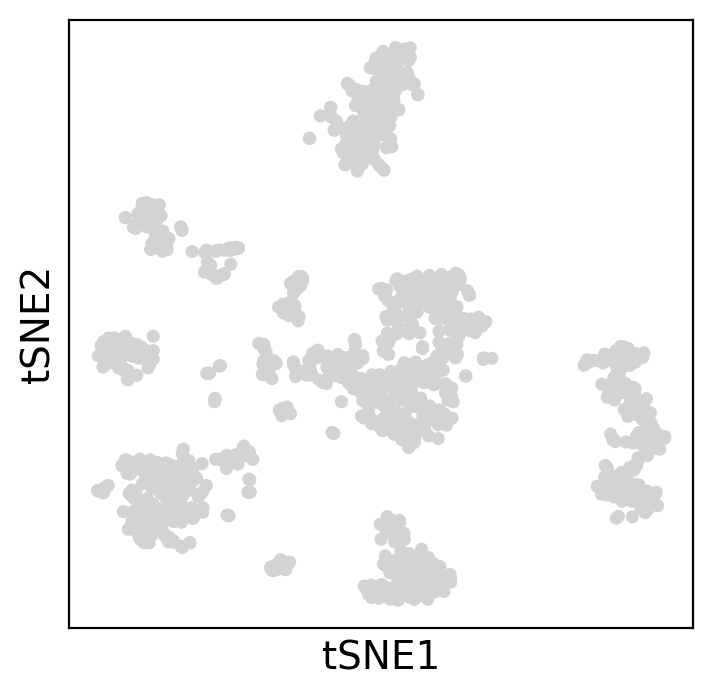

computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:06)


/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


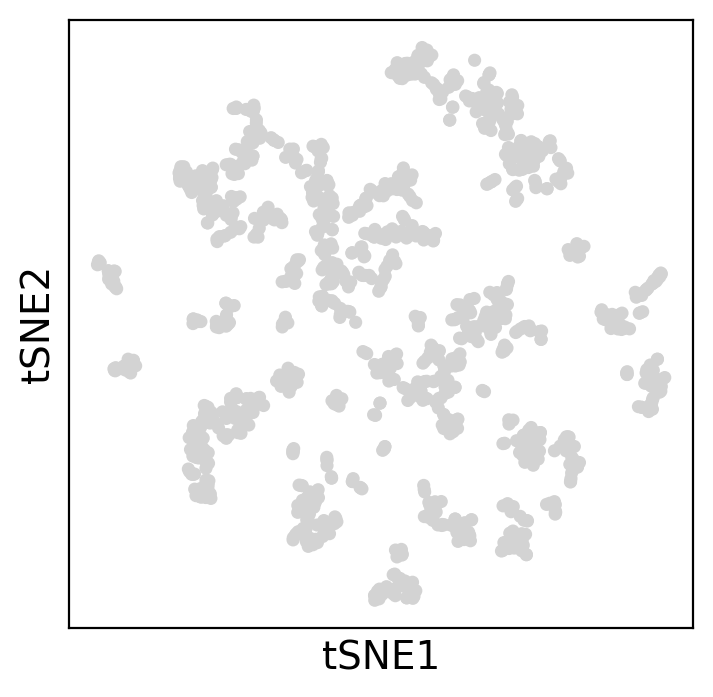

In [93]:
# k)
sc.pp.pca(adata, n_comps=30) 
sc.tl.tsne(adata, use_rep="X_pca")
sc.pl.tsne(adata)
sc.tl.tsne(adata, use_rep="X_pca", perplexity = 7)
sc.pl.tsne(adata)

### k)
The above section displays the t-SNE dimensionality reduction on the data, using first the default parameters and then changing the  “perplexity” parameter to 7. Evidently, decreasing the perplexity parameter results in a more resolved t-SNE plot, where the clusters are separated and defined more precisely.

In [94]:
!pip install igraph
!pip install louvain
import igraph as ig
import louvain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


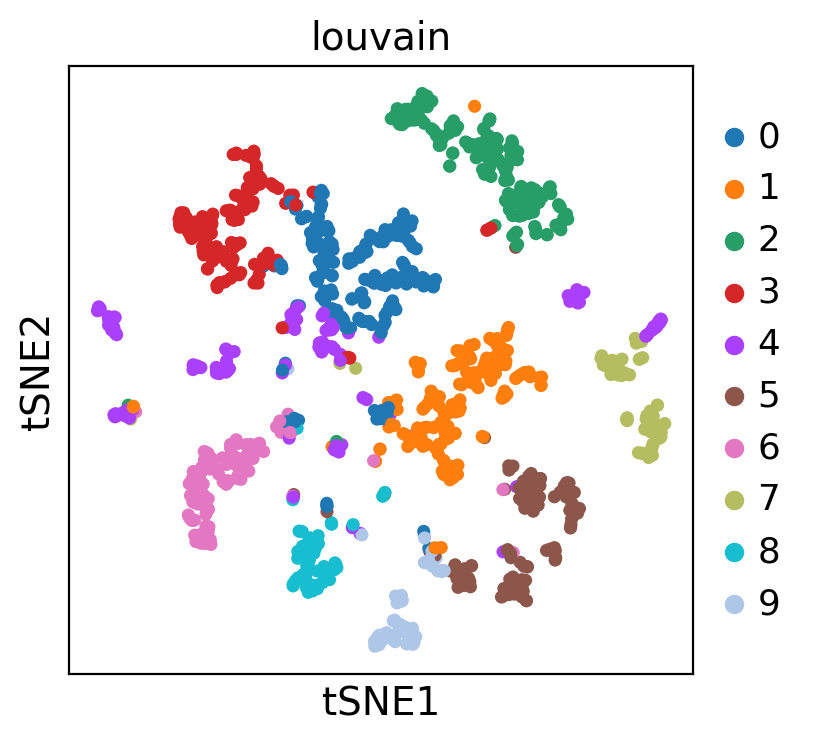

In [95]:
# l)
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=30)
sc.tl.louvain(adata)
sc.pl.tsne(adata, color=["louvain"], cmap="tab20")

### l)
As seen above, 10 clusters were found and added.

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 25 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


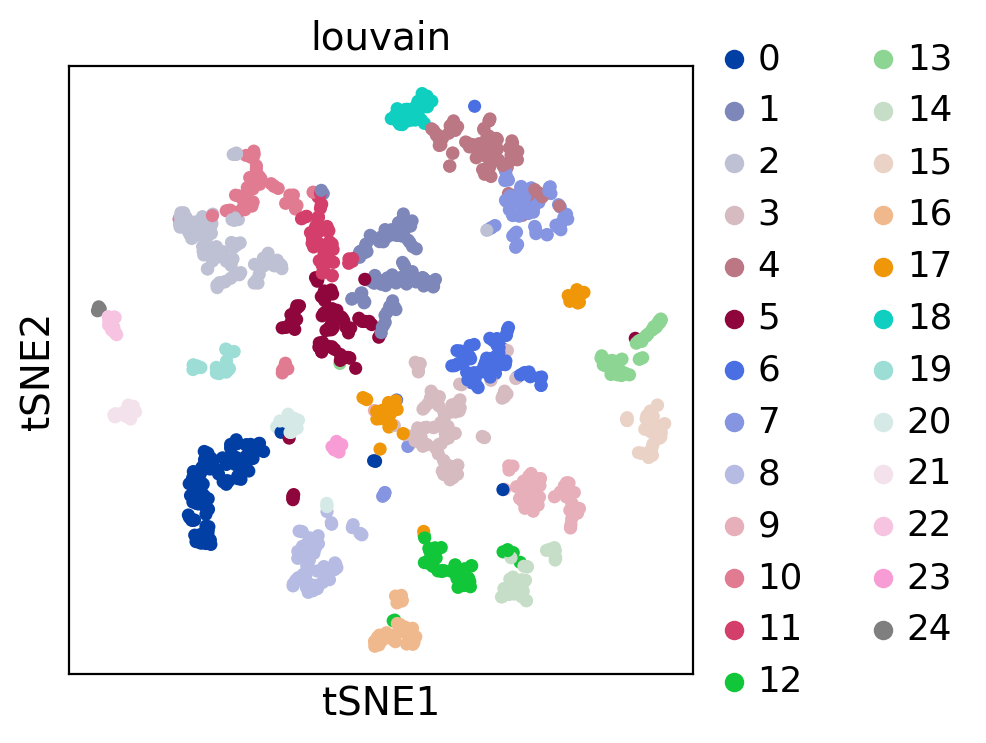

In [96]:
# li)
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=30)
sc.tl.louvain(adata)
sc.pl.tsne(adata, color=["louvain"], cmap="tab20")

### li)
As seen from the graph above, there are more clusters found and added (25 now), but this caused the clusters to be less well-defined due to reduced granularity of the clustering.

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


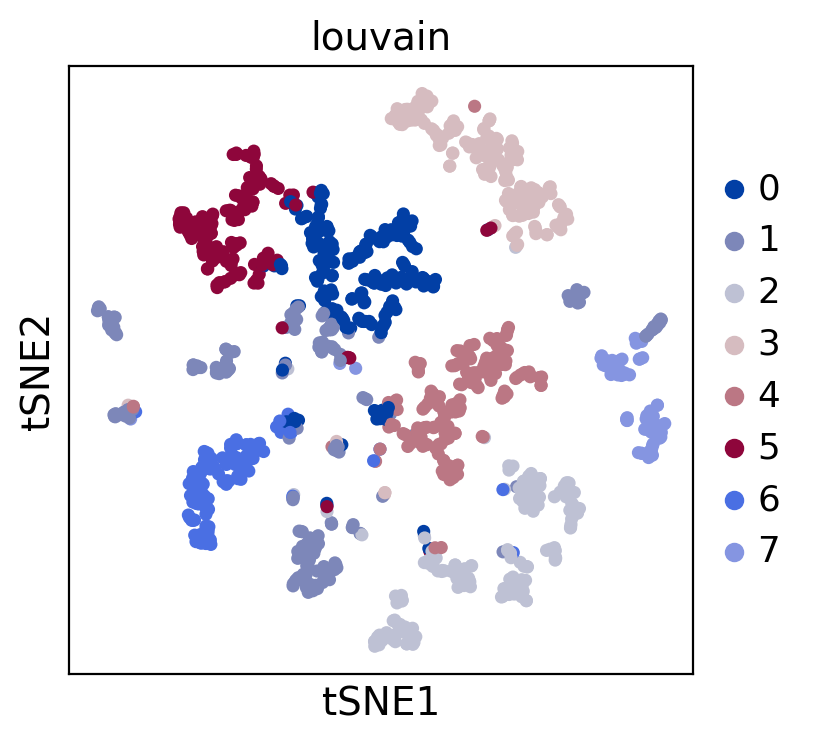

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


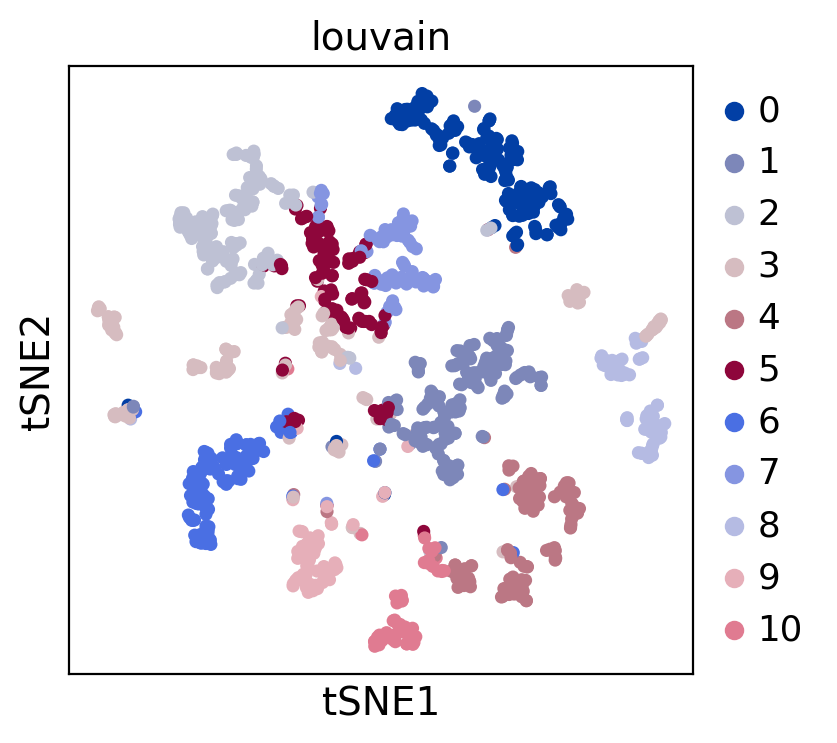

In [97]:
# lii)
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=30)
sc.tl.louvain(adata, resolution = 0.5)
sc.pl.tsne(adata, color=["louvain"],  cmap="tab20")
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=30)
sc.tl.louvain(adata, resolution = 2.0)
sc.pl.tsne(adata, color=["louvain"],  cmap="tab20")

### lii)
If the data contains many distinct cell types, then I would would want to use a higher resolution because higher resolution allows for more fine-grained clustering, which can help identify smaller cell populations and reveal more detailed information about the different cell types present in the data. 

In [98]:
# m)
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=30)
sc.tl.louvain(adata)
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon', groups='all',
reference='rest')
results = adata.uns['rank_genes_groups']

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
ranking genes


/usr/local/lib/python3.9/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.9/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.9/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.9/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.9/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.9/dist-packages/scanpy/tools/_rank_genes_groups.py:420: Runtim

    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:07)


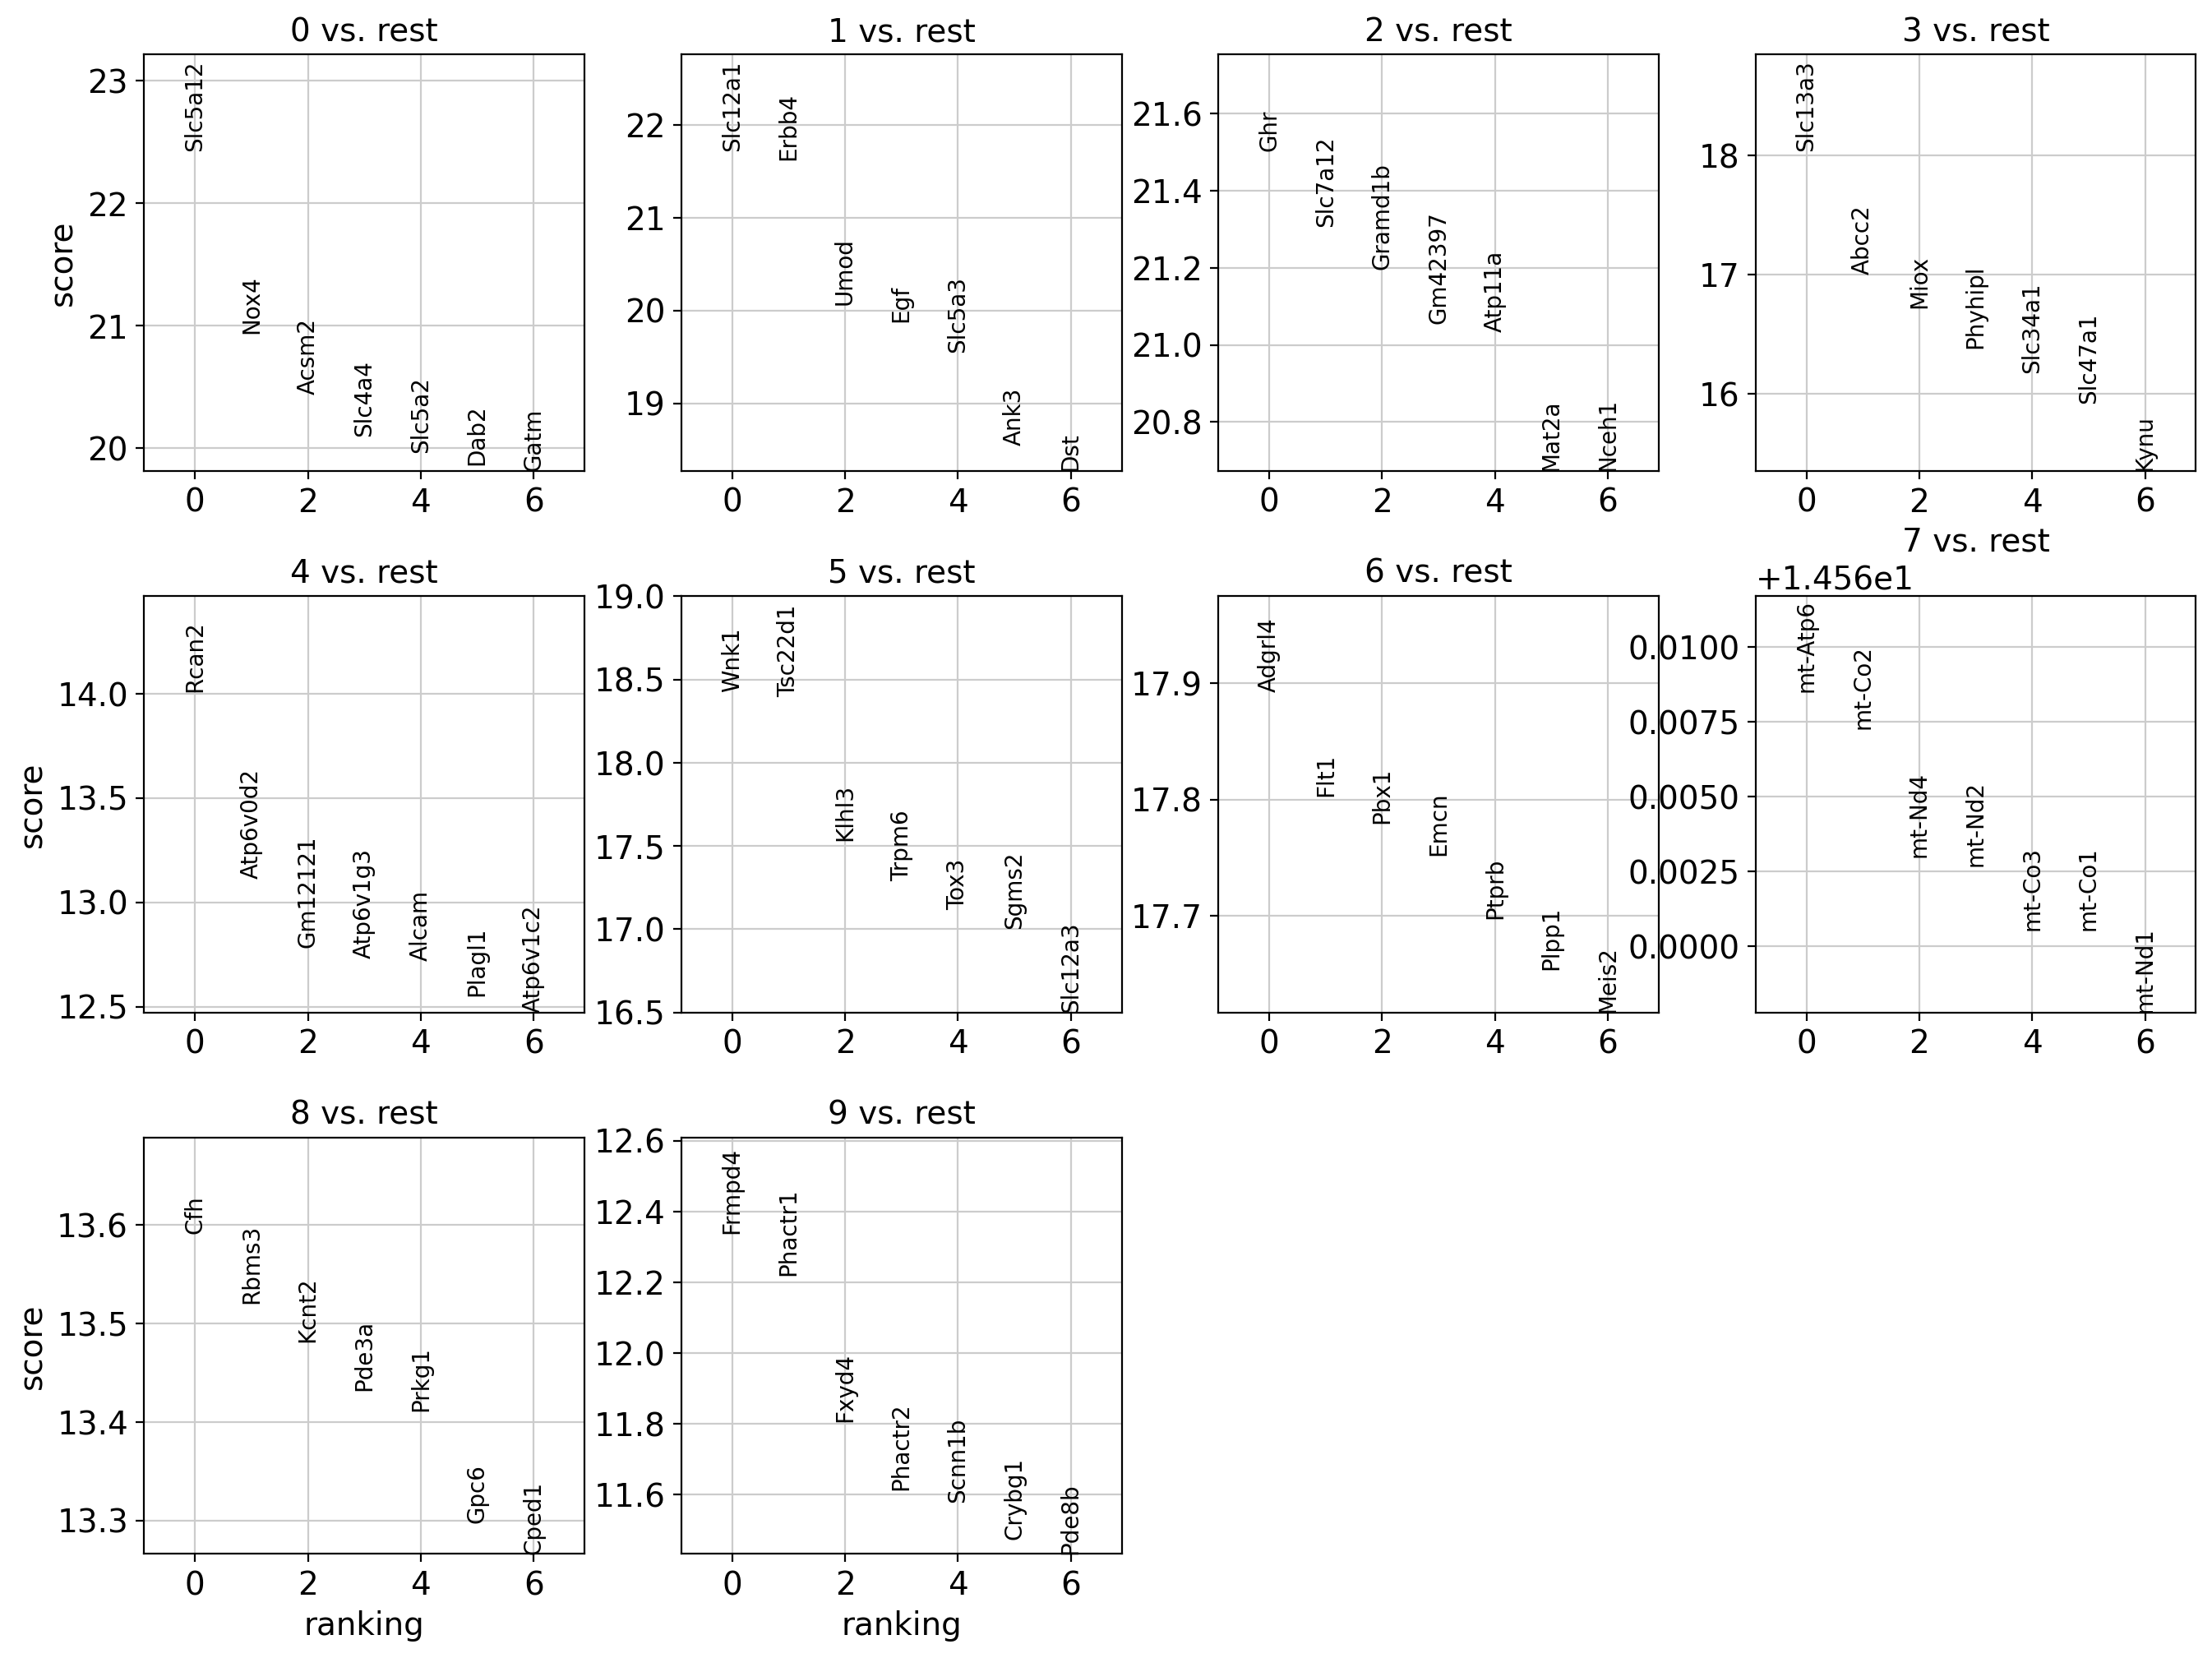

In [99]:
# mi)
sc.pl.rank_genes_groups(adata, n_genes=7, sharey=False, fontsize=10)

names Slc13a3
scores 18.038609
pvals 9.695453331200464e-73
pvals_adj 1.7071754225577778e-68
logfoldchanges nan


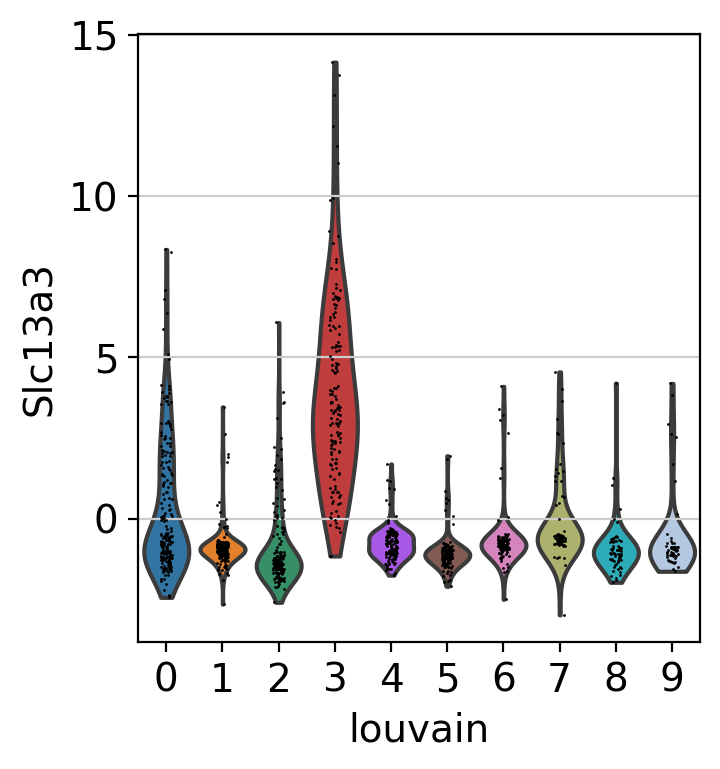

In [100]:
# mii)
for key in results:
    try: #if data structure of category allows
        print(key,results[key][0][3]) # print category and data within category, specificially data at [0][9] = first line (top gene), ninth group 
    except: #else, pass
        pass
sc.pl.violin(adata, ['Slc13a3'], groupby='louvain')

In [101]:
# miii)
df_marker_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(3) 
print(df_marker_genes)

         0        1        2        3         4        5       6        7  \
0  Slc5a12  Slc12a1      Ghr  Slc13a3     Rcan2     Wnk1  Adgrl4  mt-Atp6   
1     Nox4    Erbb4  Slc7a12    Abcc2  Atp6v0d2  Tsc22d1    Flt1   mt-Co2   
2    Acsm2     Umod  Gramd1b     Miox   Gm12121    Klhl3    Pbx1   mt-Nd4   

       8        9  
0    Cfh   Frmpd4  
1  Rbms3  Phactr1  
2  Kcnt2    Fxyd4  


computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


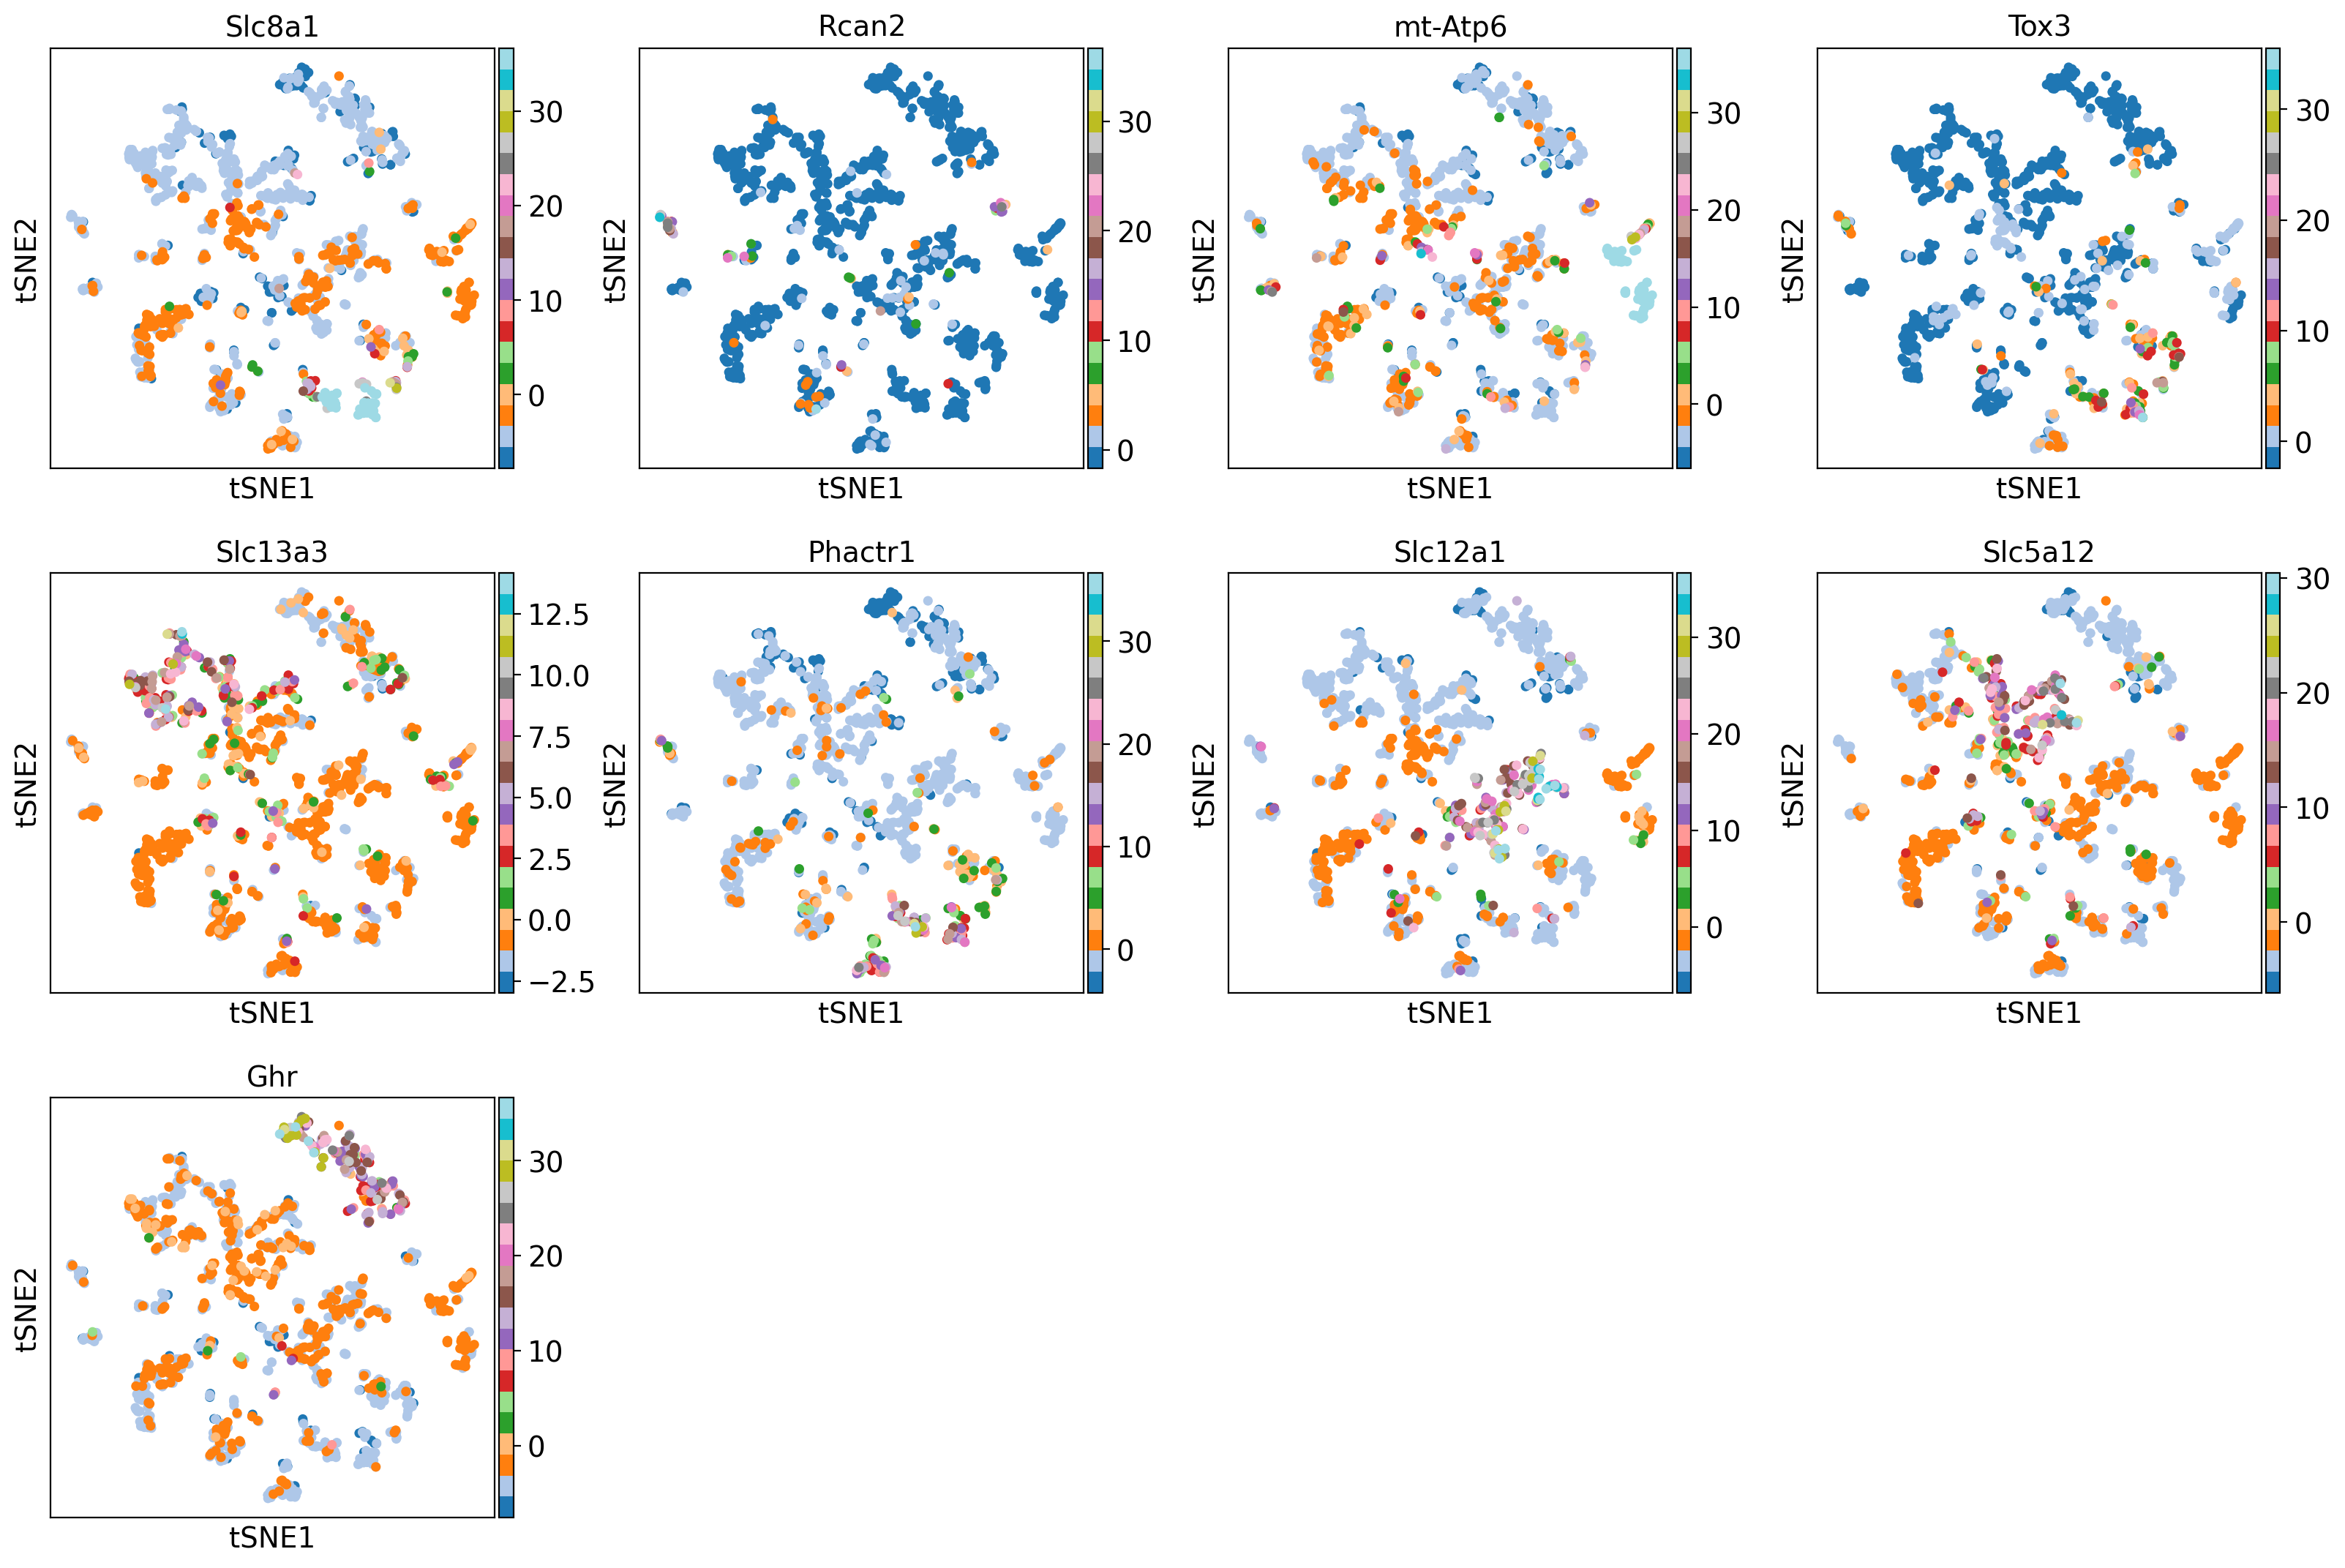

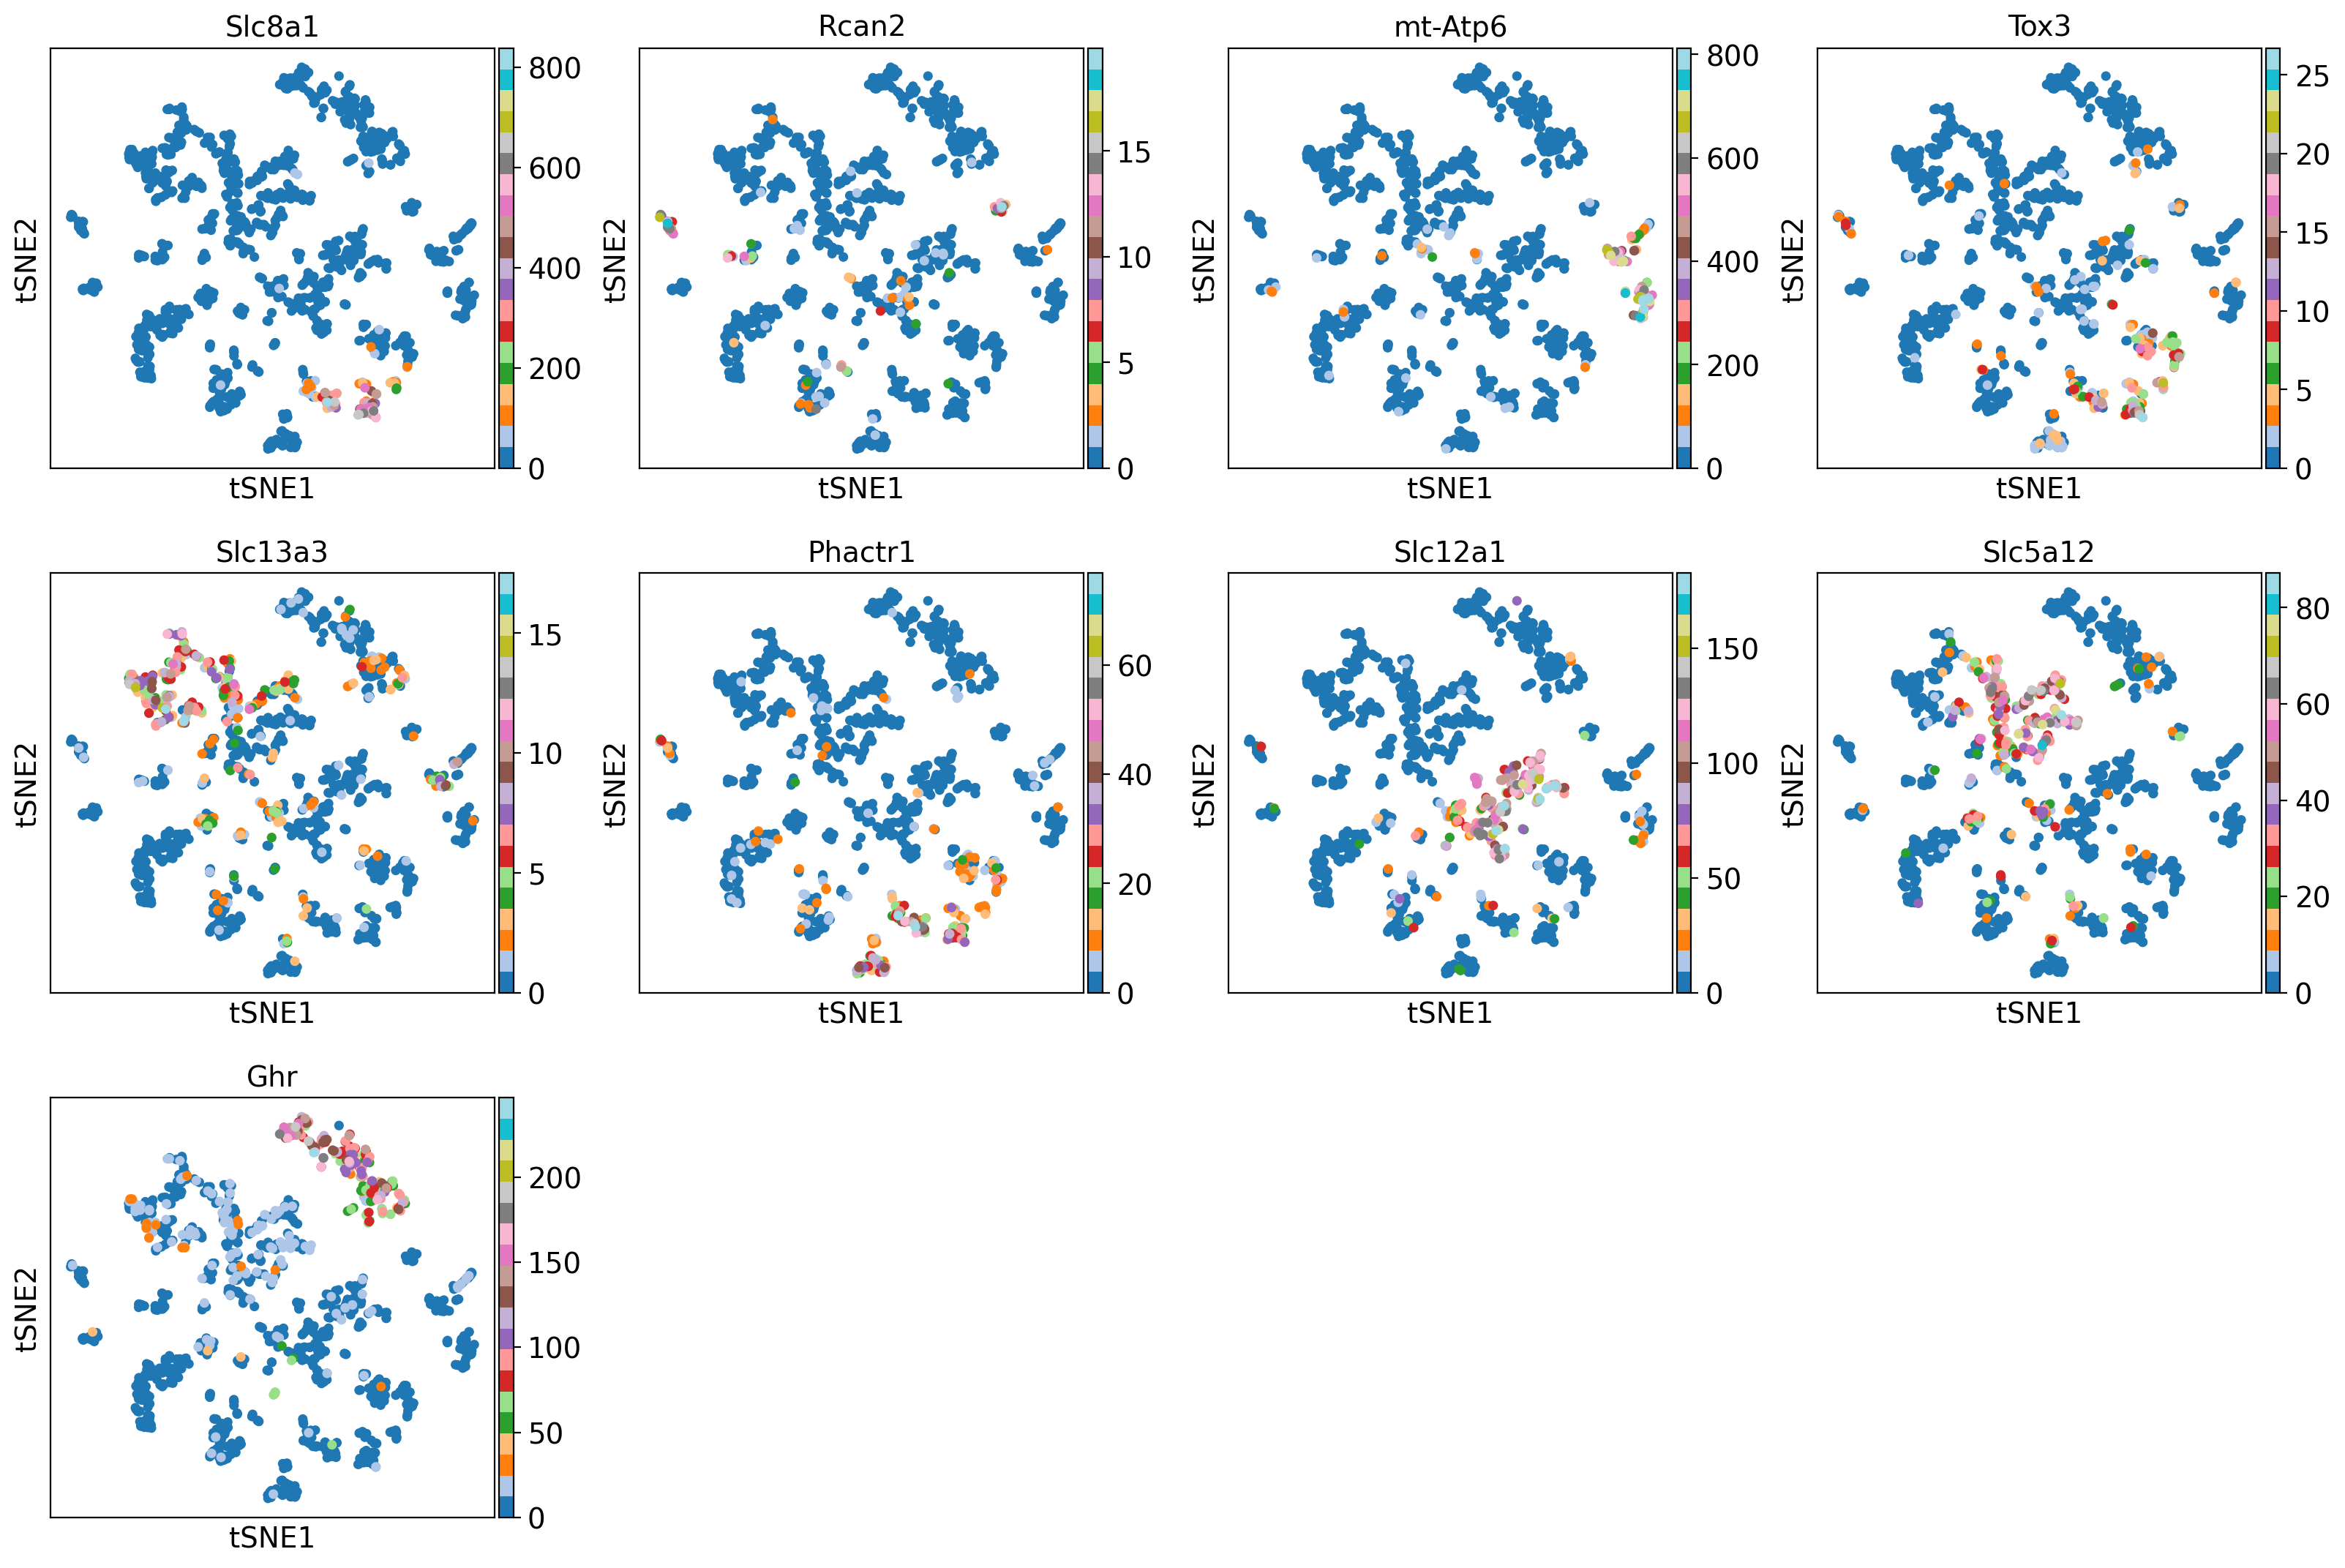

computing analytic Pearson residuals on adata.X


/usr/local/lib/python3.9/dist-packages/scanpy/experimental/pp/_normalization.py:43: UserWarning: `normalize_pearson_residuals()` expects raw count data, but non-integers were found.
  warn(


    finished (0:00:00)
running Louvain clustering


/usr/local/lib/python3.9/dist-packages/scanpy/experimental/pp/_normalization.py:59: RuntimeWarning: invalid value encountered in sqrt
  residuals = diff / np.sqrt(mu + mu**2 / theta)


    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


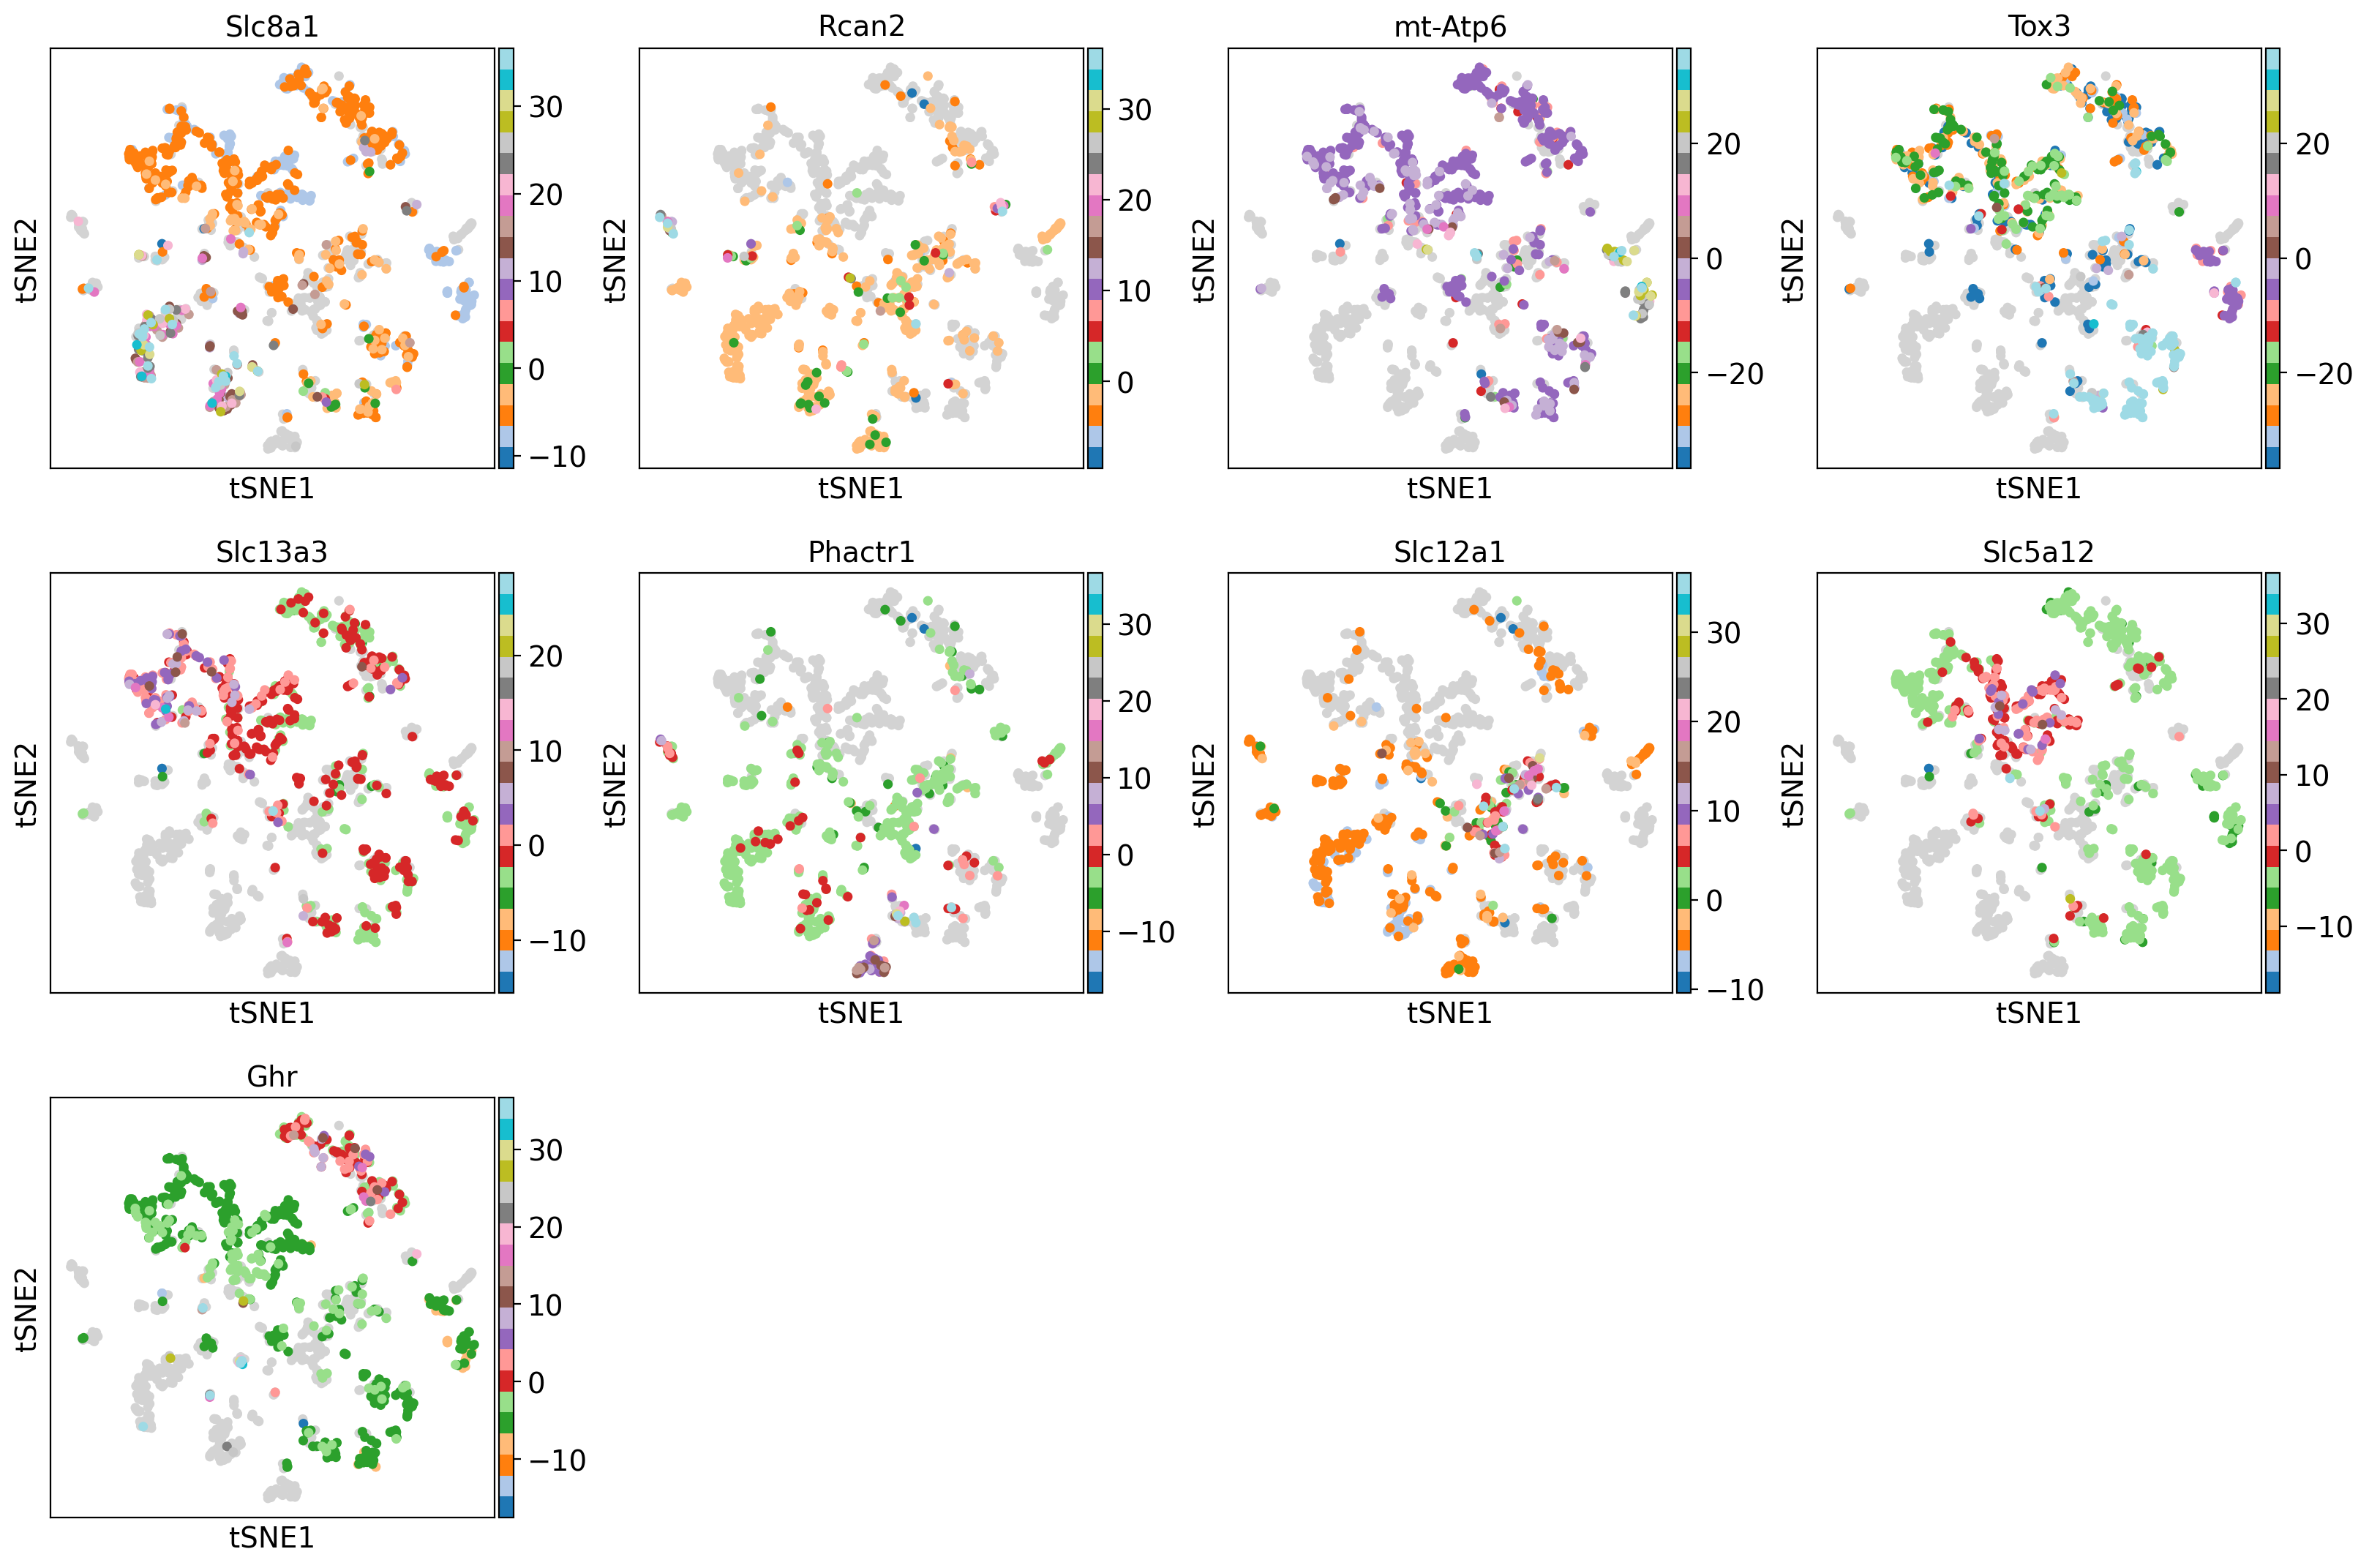

In [102]:
# miv)
markers = {'Slc5a12', 'Slc12a1', 'Ghr', 'Slc13a3', 'Rcan2', 'Tox3', 'Slc8a1', 
           'mt-Atp6', 'Slc8a1', 'Phactr1'}
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=30)
sc.tl.louvain(adata)
sc.pl.tsne(adata, color=markers, cmap="tab20")
sc.pl.tsne(adata, color=markers,  cmap="tab20", layer = "libsize_norm")
sc.experimental.pp.normalize_pearson_residuals(adata)
sc.tl.louvain(adata)
sc.pl.tsne(adata, color=markers,  cmap="tab20")

### miv)
Evidently, the results from each of these layers appear so visually different because each normalization method removes different sources of variation from the data. The different normalization methods may highlight different biological signals and result in distinct clustering patterns.

### mv)
Marker genes help us to link gene expression profiles to biological processes and functions by identifying genes that are specifically expressed in certain cell populations or conditions. These genes can provide insight into the underlying biology of the cells, including their identity, function, and state.